$ mkdir -p ~/aiffel/class_activation_map

In [ ]:
!mkdir -p ~/aiffel/class_activation_map

## CAM VS Grad-CAM

 - CAM = CNN -> GAP(Global Average Pooling) -> Softmax layer
 - Grad-CAM = 어떤 구조에서든 구현 가능
 
 

https://www.tensorflow.org/datasets/catalog/cars196
데이터셋을 사용해서 Class Activation Map 구현해보자


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [5]:
num_classes=ds_info.features['label'].num_classes

In [6]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg')
x=base_model.output
preds=keras.layers.Dense(num_classes, activation = 'softmax')(x)

In [7]:
base_model.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [8]:
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

In [9]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
def get_one(ds):
    ds=ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]
    

In [11]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [12]:
sample_model=tf.keras.models.Model()

In [42]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [43]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [15]:
import cv2 as cv
def visualize_cam_on_image(src1, src2, alpha=0.4):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [16]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

141


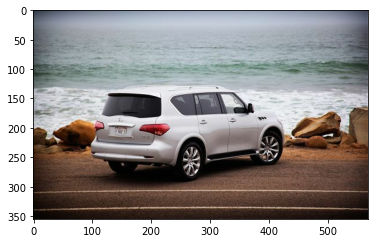

In [47]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

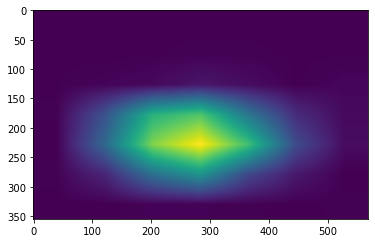

In [48]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

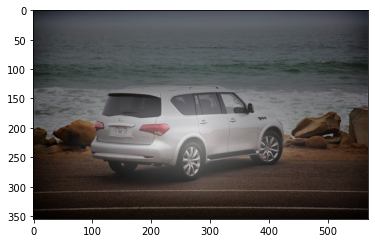

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

147


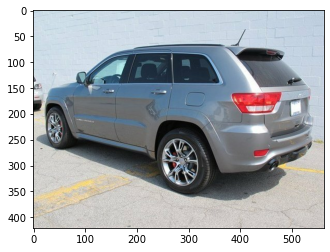

In [50]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

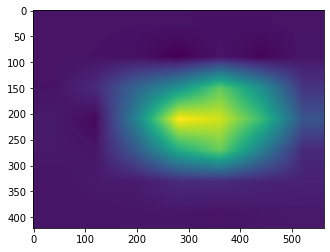

In [51]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

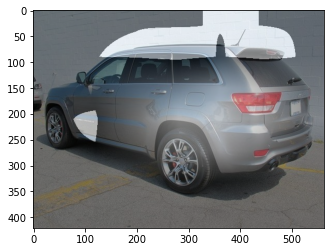

In [52]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

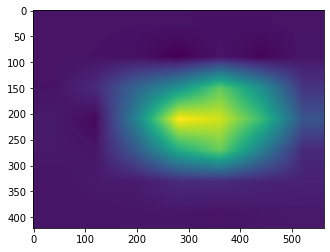

In [53]:
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
plt.imshow(cam_image)

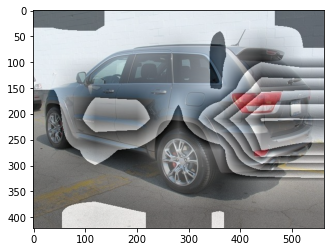

In [54]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

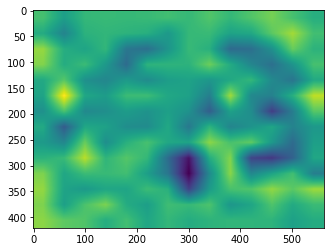

In [55]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

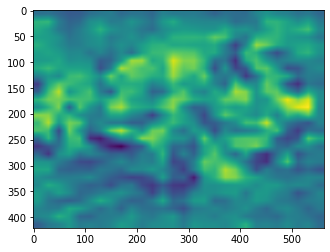

In [56]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

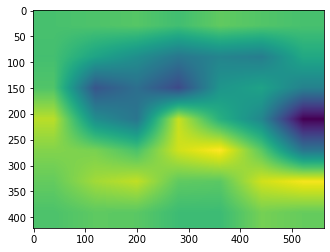

In [57]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block1_out', item)
plt.imshow(grad_cam_image)

130


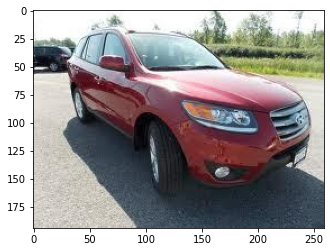

In [58]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

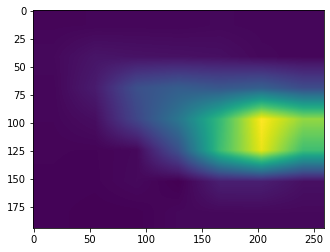

In [59]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [60]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [61]:
image_bbox = copy.deepcopy(item['image'])
image_origin = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[258, 161],
       [ 48, 161],
       [ 48,  44],
       [258,  44]])

In [62]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [63]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2268041237113402,
 0.18532818532818532,
 0.8298969072164949,
 0.9961389961389961]

In [64]:
image=item['image']

In [65]:
def get_orgin_bbox(rect):
    bbox=[[],[],[],[]]
    bbox[0].append(rect[3]*image.shape[1])
    bbox[0].append(rect[2]*image.shape[0])
    
    bbox[1].append(rect[1]*image.shape[1])
    bbox[1].append(rect[2]*image.shape[0])
    
    bbox[2].append(rect[1]*image.shape[1])
    bbox[2].append(rect[0]*image.shape[0])
    
    bbox[3].append(rect[3]*image.shape[1])
    bbox[3].append(rect[0]*image.shape[0])
    
    bbox=np.array(bbox).astype('int64')
    
    return bbox
    
    

In [66]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [82]:
def show_org_cam_bbox(item,types):
    image=item['image']
    origin_image=copy.deepcopy(image)
    origin_bbox=item['bbox']
    origin_bbox=get_orgin_bbox(origin_bbox)
    
    if types == 'cam': 
        cam_image = generate_cam(cam_model, item)
        cam_bbox = get_bbox(cam_image)
    elif types == 'grad_cam':
        cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
        cam_bbox = get_bbox(cam_image)
    
    #original bbox = Green, Cam bbox= Blue
    image_bbox = cv2.drawContours(origin_image,[origin_bbox],0,(0,255,0),3)
    image_bbox = cv2.drawContours(origin_image,[cam_bbox],0,(0,0,255),3)
    

    
    return image_bbox
    

## Green Box = 원본 bbox
## Blue Box = Cam BBOX

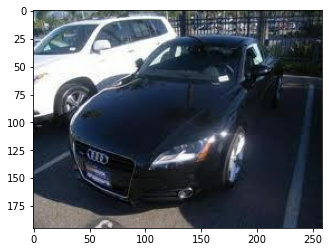

In [83]:
item = get_one(ds_test)
image=item['image']
plt.imshow(image)

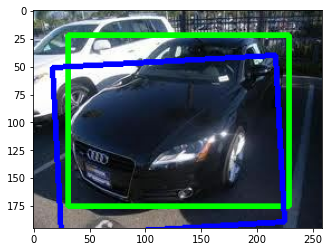

In [84]:
im=show_org_cam_bbox(item,'cam')
plt.figure()
plt.imshow(im)
#plt.imshow(item['image'])

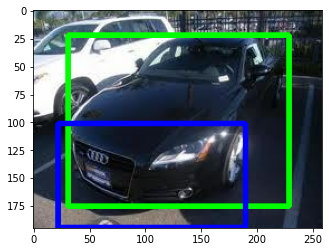

In [85]:
im=show_org_cam_bbox(item,'grad_cam')
plt.figure()
plt.imshow(im)
#plt.imshow(item['image'])

In [86]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['bbox'])

0.6906194585526807

In [87]:
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
rect = get_bbox(grad_cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['bbox'])

0.3416116463159327

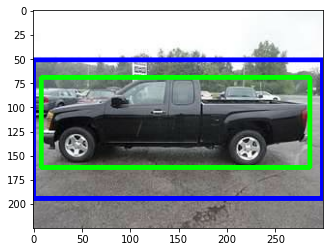

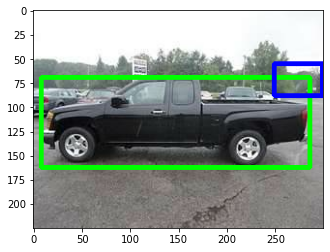

In [113]:
item = get_one(ds_test)
image=item['image']
im=show_org_cam_bbox(item,'cam')
plt.figure()
plt.imshow(im)
im=show_org_cam_bbox(item,'grad_cam')
plt.figure()
plt.imshow(im)

In [114]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
iou_cam=get_iou(pred_bbox, item['bbox'])

grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
rect = get_bbox(grad_cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
iou_grad_cam=get_iou(pred_bbox, item['bbox'])
print('IOU CAM=', iou_cam)
print('IOU Grad_CAM=', iou_grad_cam)

IOU CAM= 0.6046729609253482
IOU Grad_CAM= 0.02695839727773637


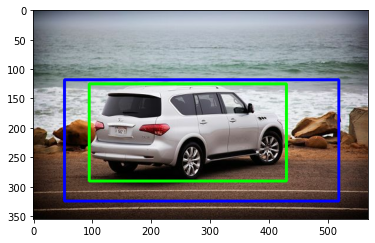

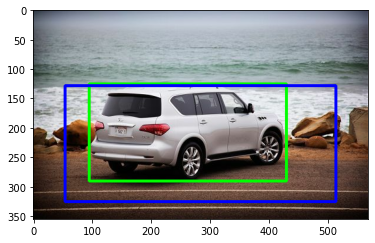

In [115]:
item = get_one(ds_test)
image=item['image']
im=show_org_cam_bbox(item,'cam')
plt.figure()
plt.imshow(im)

im=show_org_cam_bbox(item,'grad_cam')
plt.figure()
plt.imshow(im)

In [116]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
iou_cam=get_iou(pred_bbox, item['bbox'])

grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
rect = get_bbox(grad_cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
iou_grad_cam=get_iou(pred_bbox, item['bbox'])
print('IOU CAM=', iou_cam)
print('IOU Grad_CAM=', iou_grad_cam)

IOU CAM= 0.5792949632225576
IOU Grad_CAM= 0.5959618091940145


## Object Detection 의 결과, Cam과 grad-cam중 무엇이 더 뛰어나다고 판별하기에는 무리가 있는듯 하다.
## 경우에 따라서 Grad가 좋을 때도, Cam 이 더 좋을때도 있다.